In [239]:
from mesa import Agent, Model
import matplotlib.pyplot as plt
import numpy as np

In [240]:
agent_expectations = {
    "Residents (Positive)": {"Transparency": 0.4, "Inclusivity": 0.4, "Accountability": 0.3, "Outcome Fairness": 0.4},
    "Residents (Neutral)": {"Transparency": 0.6, "Inclusivity": 0.6, "Accountability": 0.5, "Outcome Fairness": 0.5},
    "Residents (Negative)": {"Transparency": 0.9, "Inclusivity": 0.9, "Accountability": 0.9, "Outcome Fairness": 0.6},
    "NGOs": {"Transparency": 0.8, "Inclusivity": 0.8, "Accountability": 0.6, "Outcome Fairness": 0.3},
    "Marginalized Groups": {"Transparency": 0.7, "Inclusivity": 0.9, "Accountability": 0.4, "Outcome Fairness": 0.4},
    "Residents (Procedural Focus)": {"Transparency": 0.8, "Inclusivity": 0.8, "Accountability": 0.7, "Outcome Fairness": 0.3},
    "Residents (Outcome Focus)": {"Transparency": 0.3, "Inclusivity": 0.3, "Accountability": 0.4, "Outcome Fairness": 0.9}
}

# sequences
sequence_events = {
    "Maximal Effort Process": [
        "Early public consultation",
        "Excursion",
        "Consultation: technology",
        "Consultation: nuisance and health",
        "Consultation: ecological impacts",
        "Consultation: noise and safety",
        "Consultation: commercial developer",
        "Consultation: local ownership",
        "Consultation: financial participation",
        "Consultation: external safety",
        "Consultation: Board authority",
        "Policy proposal",
        "Policy revision",
        "Public consultation",
        "Final decision"
    ],
    "Moderate Effort Process": [
        "Early public consultation",
        "Excursion",
        "Consultation: nuisance and health",
        "Consultation: financial participation",
        "Consultation: Board authority",
        "Policy proposal",
        "Public consultation",
        "Policy revision",
        "Final decision"
    ],
    "Basic Effort Process": [
        "Excursion",
        "Consultation: technology",
        "Policy proposal",
        "Public consultation",
        "Final decision"
    ],
    "Minimal Effort Process": [
        "Policy proposal",
        "Final decision"
    ]
}

event_impact = {
    "Early public consultation": {"Transparency": 0.9, "Inclusivity": 0.9},
    "Excursion": {"Transparency": 0.5, "Inclusivity": 0.4},
    "Consultation: technology": {"Transparency": 0.6, "Inclusivity": 0.5},
    "Consultation: nuisance and health": {"Transparency": 0.6, "Inclusivity": 0.6},
    "Consultation: ecological impacts": {"Transparency": 0.7, "Inclusivity": 0.6},
    "Consultation: noise and safety": {"Transparency": 0.7, "Inclusivity": 0.6},
    "Consultation: commercial developer": {"Transparency": 0.5, "Inclusivity": 0.4},
    "Consultation: local ownership": {"Inclusivity": 0.8, "Outcome Fairness": 0.7},
    "Consultation: financial participation": {"Outcome Fairness": 0.9, "Inclusivity": 0.7},
    "Consultation: external safety": {"Transparency": 0.7, "Accountability": 0.5},
    "Consultation: Board authority": {"Accountability": 0.6, "Transparency": 0.6},
    "Policy proposal": {"Accountability": 0.4},
    "Policy revision": {"Accountability": 0.8, "Outcome Fairness": 0.9},
    "Public consultation": {"Transparency": 0.9, "Inclusivity": 0.9},
    "Final decision": {"Outcome Fairness": 0.6},
}

# stakeholder-specific event weights

event_weights = {
    "Residents (Positive)": {
        "Consultation: local ownership": 1.2,
        "Consultation: financial participation": 1.2,
        "Public consultation": 1.1
    },
    "Residents (Neutral)": {
        "Public consultation": 1.0,
        "Consultation: nuisance and health": 1.1
    },
    "Residents (Negative)": {
        "Consultation: nuisance and health": 1.4,
        "Public consultation": 1.2,
        "Consultation: noise and safety": 1.3
    },
    "NGOs": {
        "Consultation: ecological impacts": 1.5,
        "Consultation: external safety": 1.3,
        "Consultation: noise and safety": 1.2
    },
    "Marginalized Groups": {
        "Early public consultation": 1.3,
        "Public consultation": 1.4,
        "Consultation: financial participation": 1.1,
        "Consultation: local ownership": 1.2
    },
    "Residents (Procedural Focus)": {
        "Early public consultation": 1.3,
        "Public consultation": 1.3,
        "Policy revision": 1.2
    },
    "Residents (Outcome Focus)": {
        "Consultation: financial participation": 1.4,
        "Policy revision": 1.5,
        "Final decision": 1.6
    }
}



In [241]:
# stakholder agent class

class StakeholderAgent(Agent):
    def __init__(self, unique_id, model, stakeholder_type):
        super().__init__(model)
        self.unique_id = unique_id
        self.stakeholder_type = stakeholder_type
        self.perceptions = {}
        self.reactions = {}

    def calculate_perceptions(self):
        expectations = agent_expectations[self.stakeholder_type]
        max_events = max(len(events) for events in self.model.sequence_events.values())

        for sequence, events in self.model.sequence_events.items():
            actual_scores = {"Transparency": 0, "Inclusivity": 0, "Accountability": 0, "Outcome Fairness": 0}
            dimension_counts = {"Transparency": 0, "Inclusivity": 0, "Accountability": 0, "Outcome Fairness": 0}

            # sum impacts per dimension
            for event in events:
                impacts = self.model.event_impact.get(event, {})
                # stakeholder-specific weight, else 1
                weight = event_weights.get(self.stakeholder_type, {}).get(event, 1)
                for dim in impacts:
                    actual_scores[dim] += impacts[dim] * weight  # weighted impact
                    dimension_counts[dim] += weight  # weighted count


            # penalties for missing procedural steps
            if "Policy proposal" in events:
                proposal_index = events.index("Policy proposal")
                found_consultation = any(e in ["Public consultation", "Early public consultation"] for e in events[:proposal_index])
                if not found_consultation:
                    actual_scores["Transparency"] -= 0.5
                    actual_scores["Inclusivity"] -= 0.5

            if "Policy revision" not in events:
                actual_scores["Accountability"] -= 0.5
                actual_scores["Outcome Fairness"] -= 0.5

            # average dimension scores
            addressed_dims = 0
            for dim in actual_scores:
                if dimension_counts[dim] > 0:
                    actual_scores[dim] /= dimension_counts[dim]
                    addressed_dims += 1
                else:
                    actual_scores[dim] = 0

                actual_scores[dim] = max(0, min(actual_scores[dim], 1))

            # penalties for expectations not met
            total_penalty = 0
            for dim in expectations:
                if actual_scores[dim] >= expectations[dim]:
                    penalty = 0
                else:
                    penalty = (expectations[dim] - actual_scores[dim]) ** 2
                total_penalty += penalty

            justice_score = 1 - (total_penalty / len(expectations))

            # coverage and sequence length factor
            coverage_factor = addressed_dims / len(expectations)
            sequence_length_factor = len(events) / max_events
            justice_score *= coverage_factor * sequence_length_factor
            justice_score = round(max(0, min(justice_score, 1)), 3)

            self.perceptions[sequence] = justice_score

            if justice_score >= 0.7:
                self.reactions[sequence] = "Support"
            elif justice_score >= 0.4:
                self.reactions[sequence] = "Neutral"
            else:
                self.reactions[sequence] = "Oppose"

# model class
    
class JusticeModel(Model):
    def __init__(self, procedural_pct=0.1, outcome_pct=0.1, neutral_pct=0.8):
        super().__init__()
        self.stakeholders = []
        self.sequence_events = sequence_events
        self.event_impact = event_impact
        
        # resident distribution
        self.resident_distribution = {
            "Residents (Procedural Focus)": procedural_pct,
            "Residents (Outcome Focus)": outcome_pct,
            "Residents (Neutral)": neutral_pct
        }
        
        # fixed agent types
        fixed_agent_types = [
            "Residents (Positive)",
            "Residents (Negative)",
            "NGOs",
            "Marginalized Groups"
        ]
        agent_id = 0
        for name in fixed_agent_types:
            agent = StakeholderAgent(agent_id, self, name)
            self.stakeholders.append(agent)
            agent_id += 1
        
        # 100 resident agents with adjustable distribution
        total_residents = 100 
        for res_type, pct in self.resident_distribution.items():
            count = int(total_residents * pct)
            for _ in range(count):
                agent = StakeholderAgent(agent_id, self, res_type)
                self.stakeholders.append(agent)
                agent_id += 1


    def step(self):
        for agent in self.stakeholders:
            agent.calculate_perceptions()



Residents (Positive)
  Maximal Effort Process: average score = 1.0, reaction = (Support)
  Moderate Effort Process: average score = 0.6, reaction = (Neutral)
  Basic Effort Process: average score = 0.318, reaction = (Oppose)
  Minimal Effort Process: average score = 0.058, reaction = (Oppose)

Residents (Neutral)
  Maximal Effort Process: average score = 0.998, reaction = (Support)
  Moderate Effort Process: average score = 0.6, reaction = (Neutral)
  Basic Effort Process: average score = 0.293, reaction = (Oppose)
  Minimal Effort Process: average score = 0.048, reaction = (Oppose)

Residents (Negative)
  Maximal Effort Process: average score = 0.944, reaction = (Support)
  Moderate Effort Process: average score = 0.575, reaction = (Neutral)
  Basic Effort Process: average score = 0.217, reaction = (Oppose)
  Minimal Effort Process: average score = 0.022, reaction = (Oppose)

NGOs
  Maximal Effort Process: average score = 0.989, reaction = (Support)
  Moderate Effort Process: average

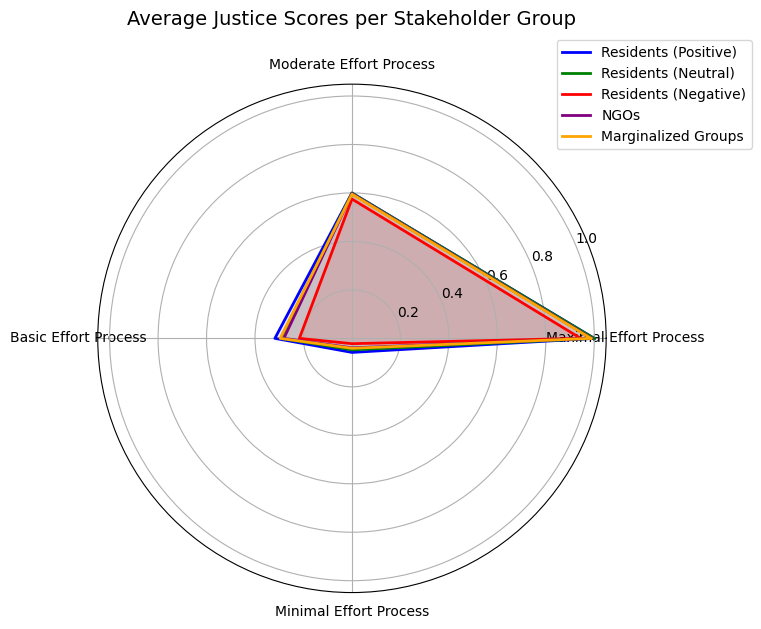

In [ ]:
# run model
model = JusticeModel()
model.step()

# output
group_mapping = {
    "Residents (Positive)": "Residents (Positive)",
    "Residents (Negative)": "Residents (Negative)",
    "Residents (Neutral)": "Residents (Neutral)",
    "Residents (Procedural Focus)": "Residents (Neutral)",
    "Residents (Outcome Focus)": "Residents (Neutral)",
    "NGOs": "NGOs",
    "Marginalized Groups": "Marginalized Groups"
}

total_scores = {}
counts = {}

for agent in model.stakeholders:
    group = group_mapping[agent.stakeholder_type]
    
    if group not in total_scores:
        total_scores[group] = {}
        counts[group] = {}
        for sequence in sequence_events:
            total_scores[group][sequence] = 0
            counts[group][sequence] = 0
    
    for sequence in sequence_events:
        total_scores[group][sequence] += agent.perceptions[sequence]
        counts[group][sequence] += 1

for group in ["Residents (Positive)", "Residents (Neutral)", "Residents (Negative)", "NGOs", "Marginalized Groups"]:
    print(f"\n{group}")
    for sequence in sequence_events:
        avg_score = total_scores[group][sequence] / counts[group][sequence]
        avg_score = round(avg_score, 3)
        
        if avg_score >= 0.7:
            reaction = "Support"
        elif avg_score >= 0.4:
            reaction = "Neutral"
        else:
            reaction = "Oppose"
        
        print(f"  {sequence}: average score = {avg_score}, reaction = ({reaction})")


# visualization
group_labels = ["Residents (Positive)", "Residents (Neutral)", "Residents (Negative)", "NGOs", "Marginalized Groups"]
sequence_labels = ["Maximal Effort Process", "Moderate Effort Process", "Basic Effort Process", "Minimal Effort Process"]

angles = np.linspace(0, 2 * np.pi, len(sequence_labels), endpoint=False).tolist()
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, group in enumerate(group_labels):
    scores = []
    for sequence in sequence_labels:
        avg_score = total_scores[group][sequence] / counts[group][sequence]
        scores.append(avg_score)
    scores += scores[:1]  
    
    ax.plot(angles, scores, label=group, color=colors[i], linewidth=2)
    ax.fill(angles, scores, color=colors[i], alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(sequence_labels)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_title("Average Justice Scores per Stakeholder Group", size=14, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()